# Time series forecasting Hourly Energy Consumption using Deep Neural Net models

Dependencies

In [107]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from matplotlib import dates
import plotly.graph_objs as go

Available GPU for Tensorflow

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
df_energy = pd.read_csv('../data/AEP_hourly.csv')

In [8]:
df_energy.shape

(121273, 2)

In [9]:
df_energy.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


Null values check

In [10]:
df_energy.isnull().sum()

Datetime    0
AEP_MW      0
dtype: int64

Statistics

In [11]:
df_energy.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AEP_MW,121273.0,15499.513717,2591.399065,9581.0,13630.0,15310.0,17200.0,25695.0


Plot occurrence of outliers

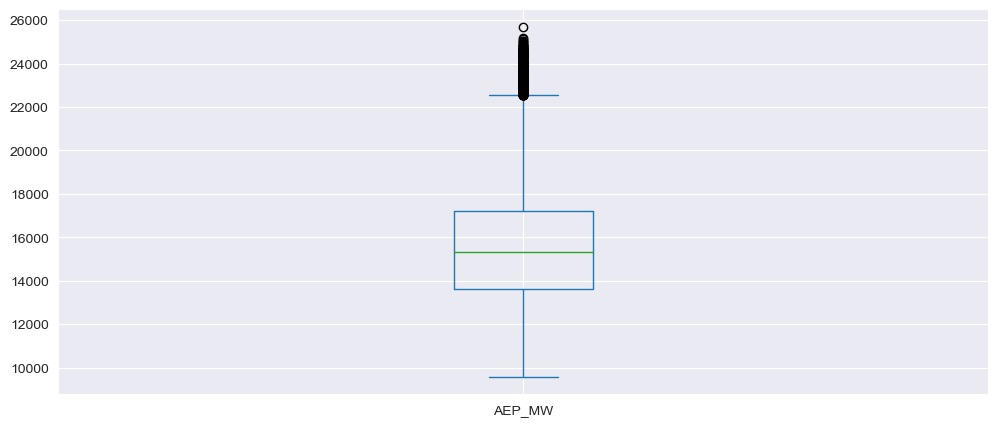

In [12]:
df_energy.AEP_MW.plot.box(subplots=True, figsize=(12, 5));

Let's detect statistically the outliers by using zscore along with transforming the numerical values into positive values.

$$ z = {x-\mu \over \sigma} $$
$$ zscore = {|z|} $$


In [13]:
z_scores = np.abs(stats.zscore(df_energy.AEP_MW))

Now, only the values that are lower than 3 std are selected as no outlier

In [14]:
no_outliers = z_scores < 3
df_no_outliers = df_energy[no_outliers]

In [15]:
df_no_outliers.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [16]:
print(f'Removed: {len(df_energy) - len(df_no_outliers)}')

Removed: 259


In [25]:
df_no_outliers['Jdate'] = pd.to_datetime(df_no_outliers.Datetime).dt.date

/var/folders/bh/hhr2wkwn2ldcpz5w4tgn7sb80000gn/T/ipykernel_18895/647404409.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['Jdate'] = pd.to_datetime(df_no_outliers.Datetime).dt.date


In [26]:
cols = ['Jdate', 'AEP_MW']
df_general_consumption = df_no_outliers[cols].groupby('Jdate').sum()

In [27]:
df_general_consumption.head()

,AEP_MW
Jdate,
2004-10-01,328544.0
2004-10-02,311997.0
2004-10-03,293450.0
2004-10-04,343417.0
2004-10-05,346553.0


In [28]:
df_general_consumption = df_general_consumption.reset_index()
df_general_consumption.head()

,Jdate,AEP_MW
0,2004-10-01,328544.0
1,2004-10-02,311997.0
2,2004-10-03,293450.0
3,2004-10-04,343417.0
4,2004-10-05,346553.0


In [101]:
df_r_win = df_general_consumption.copy()
df_r_win['win'] = df_r_win.AEP_MW.rolling(window=30).mean()

Plotting General Sales Trend with Plotly, interactive graph

In [ ]:
def plot_dataset(df, df_mu, title):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=df.index,
        y=df.AEP_MW,
        mode="lines+markers",
        name="megawatt energy",
        marker=dict(),
        text=df.index,
        line=dict(color="lightblue")
    ))

    # MU
    fig.add_trace(go.Scatter(
        x=df_mu.index,
        y=df_mu.win,
        mode="lines",
        name="mu",
        marker=dict(),
        text=df.index,
        line=dict(color="red")
    ))

    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title="MW Energy", ticklen=5, zeroline=False),
        showlegend=True,
        plot_bgcolor="white"
    )

    fig.update_layout(layout)
    fig.show()

In [106]:
plot_dataset(df_general_consumption.set_index('Jdate'), df_r_win.set_index('Jdate'), 'General Energy consumption trend: American Electric Power')

In [34]:
df_no_outliers = df_no_outliers.drop('Jdate', axis=1)

Transforming time

In [35]:
df_no_outliers.Datetime = pd.to_datetime(df_no_outliers.Datetime)

In [36]:
df_no_outliers['Hour'] = df_no_outliers.Datetime.dt.hour
df_no_outliers['DayOfWeek'] = df_no_outliers.Datetime.dt.day_of_week
df_no_outliers['Month'] = df_no_outliers.Datetime.dt.month
df_no_outliers['WeekOfYear'] = df_no_outliers.Datetime.dt.isocalendar().week

As the interest lies on daily periodicity, the datetime feature needs to be transformed in sine and cosine to obtain additional features for Hour, DayOfWeek, Month, WeekOfYear. This transformation allows for useful model input and gives the model access to the most important frequency features.

In [38]:
def gen_cyclical_features(df, feature_name, period, start_num=0):
    kwargs = {
        f'Sin_{feature_name}' : lambda x: np.sin(2*np.pi*(df[feature_name]-start_num)/period),
        f'Cos_{feature_name}' : lambda x: np.cos(2*np.pi*(df[feature_name]-start_num)/period)
    }
    return df.assign(**kwargs).drop(columns=[feature_name])

In [39]:
df_no_outliers = gen_cyclical_features(df_no_outliers, 'Hour', 24)
df_no_outliers = gen_cyclical_features(df_no_outliers, 'DayOfWeek', 7)
df_no_outliers = gen_cyclical_features(df_no_outliers, 'Month', 12, 1)
df_no_outliers = gen_cyclical_features(df_no_outliers, 'WeekOfYear', 52)

In [40]:
df_before_training = df_no_outliers.set_index('Datetime')
df_before_training.head()

,AEP_MW,Sin_Hour,Cos_Hour,Sin_DayOfWeek,Cos_DayOfWeek,Sin_Month,Cos_Month,Sin_WeekOfYear,Cos_WeekOfYear
Datetime,,,,,,,,,
2004-12-31 01:00:00,13478.0,0.258819,0.965926,-0.433884,-0.900969,-0.5,0.866025,0.120537,0.992709
2004-12-31 02:00:00,12865.0,0.500000,0.866025,-0.433884,-0.900969,-0.5,0.866025,0.120537,0.992709
2004-12-31 03:00:00,12577.0,0.707107,0.707107,-0.433884,-0.900969,-0.5,0.866025,0.120537,0.992709
2004-12-31 04:00:00,12517.0,0.866025,0.500000,-0.433884,-0.900969,-0.5,0.866025,0.120537,0.992709
2004-12-31 05:00:00,12670.0,0.965926,0.258819,-0.433884,-0.900969,-0.5,0.866025,0.120537,0.992709


The data is not randomly shuffled before splitting in order to ensure that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [41]:
df_final_features = df_before_training.copy()
df_final_features = df_final_features.reset_index()

In [42]:
date_time = df_final_features.pop('Datetime')

In [43]:
df_final_features.columns

Index(['AEP_MW', 'Sin_Hour', 'Cos_Hour', 'Sin_DayOfWeek', 'Cos_DayOfWeek',
       'Sin_Month', 'Cos_Month', 'Sin_WeekOfYear', 'Cos_WeekOfYear'],
      dtype='object')

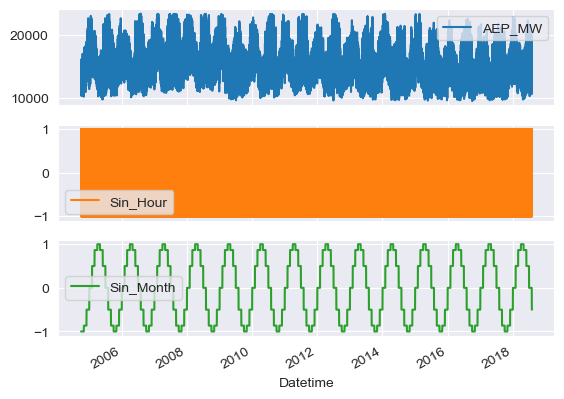

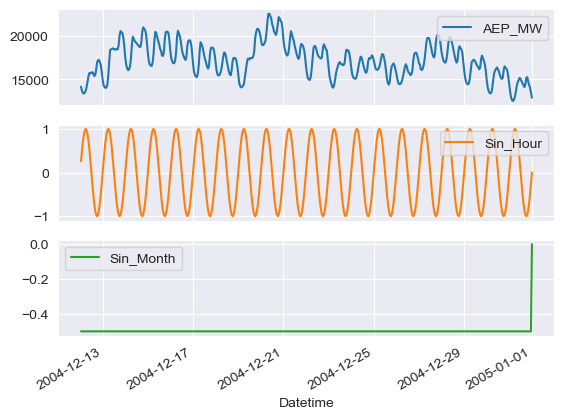

In [44]:
cols = ['AEP_MW', 'Sin_Hour', 'Sin_Month']
plot_features = df_final_features[cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df_final_features[cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

Split data into Train, Val and Test

In [45]:
column_indices = {name: i for i, name in enumerate(df_before_training.columns)}

n = len(df_final_features)

train_df = df_final_features[0:int(n*0.7)]
val_df = df_final_features[int(n*0.7):int(n*0.9)]
test_df = df_final_features[int(n*0.9):]

num_features = len(df_final_features.columns)

In [46]:
train_df.shape, val_df.shape, test_df.shape

((84709, 9), (24203, 9), (12102, 9))

Normalize data before training a neural network

In [47]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Plot normalized features

In [48]:
df_final_features.keys()

Index(['AEP_MW', 'Sin_Hour', 'Cos_Hour', 'Sin_DayOfWeek', 'Cos_DayOfWeek',
       'Sin_Month', 'Cos_Month', 'Sin_WeekOfYear', 'Cos_WeekOfYear'],
      dtype='object')

In [49]:
df_std = (df_final_features - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

# to avoid object array error, so this is a fix transforming it to the expected data type
fix = pd.DataFrame(df_std.to_dict())

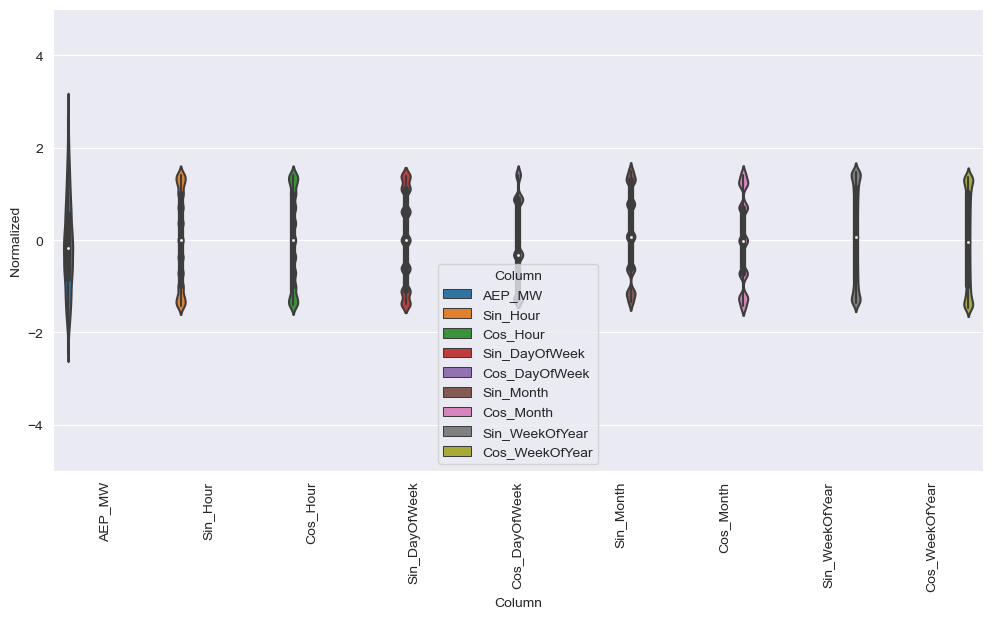

In [50]:
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', hue='Column', data=fix)
ax.set_ylim([-5, 5])
_ = ax.set_xticklabels(df_final_features.keys(), rotation=90)

Data windowing

- single prediction 24 hours into the future given a history of 24 hours results in total width of 48
- a prediction 1 hour into the future given a history of 6 hours results in total width of 7
- 1 label width equals 1 index, so total width of eg 7 means 7 labels

input width = 24    ,    offset = 24
---------------------------|--------------------
[t=0][t=1]...[t=23][t=24][t=25]...[t=47]

total width = 48

## Window creator
Here we are interested in the implementation of a Window creator for sliding over distributed datetime e.g. in order to utilize past n historical hours to predict n hour into the future.

In [51]:
class WindowGen:

  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):

    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters
    self.input_width = input_width
    self.label_width = label_width

    # shift represents the offset
    self.shift = shift

    self.total_window_size = input_width + shift

    # for slicing e.g. slice(0, 6) = start 0, stop 6, step 1
    self.input_slice = slice(0, input_width)

    # e.g. slicing an array with n steps, equal to -> np.arrange(10)[0:10:2] = {0, 2, 4, 6, 8} = slice(0, 10, 2)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]


  def split_window(self, features):
      """
      Transforms features into a window of inputs and labels
      :param features: set of features consisting of inputs and labels
      :return: window of inputs and labels
      """
      inputs = features[:, self.input_slice, :]
      labels = features[:, self.labels_slice, :]

      if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

      # Slicing doesn't preserve static shape information, so set the shapes
      # manually. This way the `tf.data.Datasets` are easier to inspect.
      inputs.set_shape([None, self.input_width, None])
      labels.set_shape([None, self.label_width, None])

      return inputs, labels


  def plot(self, plot_col, model=None, max_subplots=3):
      inputs, labels = self.example
      plt.figure(figsize=(12, 8))
      plot_col_index = self.column_indices[plot_col]
      max_n = min(max_subplots, len(inputs))
      for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
          label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
          label_col_index = plot_col_index

        if label_col_index is None:
          continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
          predictions = model(inputs)
          plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
          plt.legend()

      plt.xlabel('Time [h]')

  def make_dataset(self, data):
      data = np.array(data, dtype=np.float32)
      ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

      ds = ds.map(self.split_window)

      return ds

  @property
  def train(self):
      return self.make_dataset(self.train_df)

  @property
  def val(self):
      return self.make_dataset(self.val_df)

  @property
  def test(self):
      return self.make_dataset(self.test_df)

  @property
  def example(self):
      """
      For caching example batch of inputs labels for plotting
      :return: example
      """
      result = getattr(self, '_example', None)
      if result is None:
          result = next(iter(self.train))
          self._example = result

      return result

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

An example of a prediction of 1 hour into the future given a history of 6 hours with label width 1

In [52]:
w = WindowGen(input_width=10, label_width=1, shift=1,
                     label_columns=['AEP_MW'])
w

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10]
Label column name(s): ['AEP_MW']

Example splitted window

In [53]:
example_window = tf.stack([np.array(train_df[:w.total_window_size]),
                           np.array(train_df[100:100+w.total_window_size]),
                           np.array(train_df[200:200+w.total_window_size])])

example_inputs, example_labels = w.split_window(example_window)

Metal device set to: Apple M1 Pro


2022-10-05 13:43:20.734052: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-05 13:43:20.734178: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [54]:
print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 11, 9)
Inputs shape: (3, 10, 9)
Labels shape: (3, 1, 1)


2022-10-05 13:43:27.354679: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


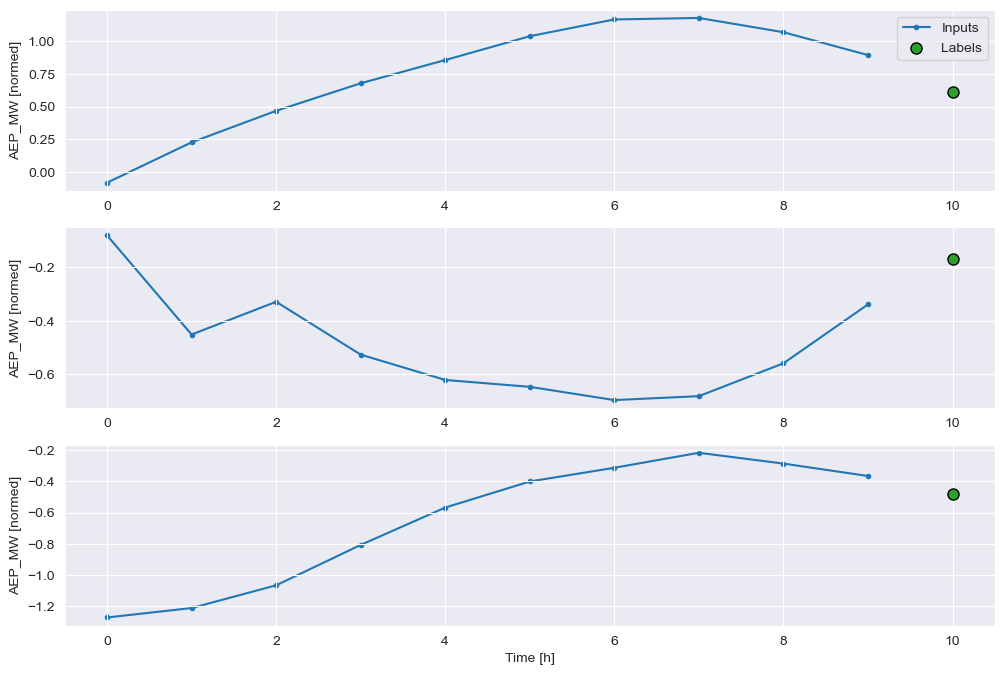

In [55]:
w.plot(plot_col='AEP_MW');

Inspec the Tensor data structure

In [56]:
w.train.element_spec

(TensorSpec(shape=(None, 10, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [57]:
for example_inputs, example_labels in w.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 10, 9)
Labels shape (batch, time, features): (32, 1, 1)


## Applying Baseline Model
- Single Model prediction into the future
- A single model predicts only a single features value, e.g. energy consumption. A multi would predict a set of features values, e.g. energy consumption and price.

In [58]:
history = 1
future = 1
features = ['AEP_MW']

single_step_window = WindowGen(
    input_width=history, label_width=1, shift=future,
    label_columns=features)

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['AEP_MW']

Structure of the Tensor training dataset

In [59]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 9)
Labels shape (batch, time, features): (32, 1, 1)


In [60]:
class Baseline(tf.keras.Model):
    """
    Baseline for comparison of multi models
    """
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs, training=None, mask=None):
        if self.label_index is None:
          return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [61]:
column_indices = {name: i for i, name in enumerate(df_final_features.columns)}

### Train

In [62]:
baseline = Baseline(label_index=column_indices['AEP_MW'])
baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.losses.MeanAbsoluteError()])

val_perform = {'Baseline':baseline.evaluate(single_step_window.val)}
perform = {'Baseline':baseline.evaluate(single_step_window.test, verbose=0)}

  1/757 [..............................] - ETA: 3:10 - loss: 0.0211 - mean_absolute_error: 0.1029

2022-10-05 13:44:06.852229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


757/757 [==============================] - 3s 3ms/step - loss: 0.0599 - mean_absolute_error: 0.1743


In order to validate the performance lets apply more samples. This can be achieved by creating a new Window with a history of 24h and future prediction of 1h.

In [63]:
wider_window = WindowGen(
    input_width=24, label_width=24, shift=1,
    label_columns=['AEP_MW'])

wider_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['AEP_MW']

In [64]:
print('Input shape:', wider_window.example[0].shape)
print('Output shape:', baseline(wider_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


Labels shifted 1 hour to the right

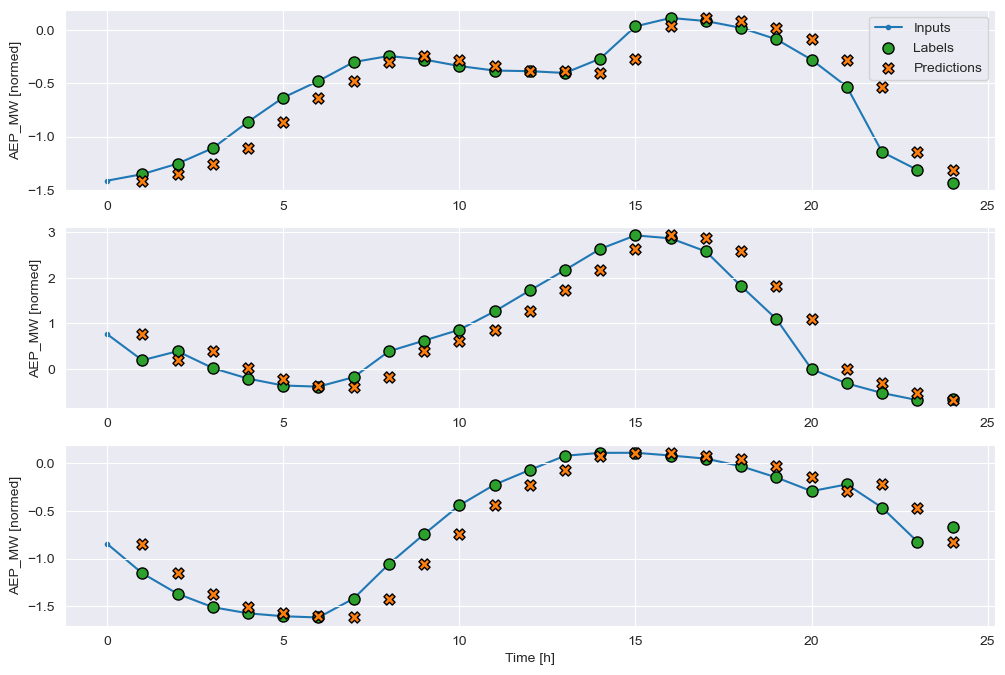

In [65]:
wider_window.plot(plot_col='AEP_MW', model=baseline)

In the plot above blue line depicts Total sale at each time step, green dot represents the target prediction value and the orange the predicted value at each time step.

## Applying Linear Model
Here no activation layer is applied in order to remain a linear model

In [66]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [67]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 9)
Output shape: (32, 1, 1)


In [68]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')


    # Compile the model
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    # Compute fit
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

### Train

In [69]:
history = compile_and_fit(linear, single_step_window)

val_perform['Linear'] = linear.evaluate(single_step_window.val)
perform['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


2022-10-05 13:44:42.369761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2647/2648 [============================>.] - ETA: 0s - loss: 0.6175 - mean_absolute_error: 0.5463

2022-10-05 13:44:55.820816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2648/2648 [==============================] - 16s 6ms/step - loss: 0.6174 - mean_absolute_error: 0.5463 - val_loss: 0.0649 - val_mean_absolute_error: 0.1974
Epoch 2/20
2648/2648 [==============================] - 17s 6ms/step - loss: 0.0522 - mean_absolute_error: 0.1705 - val_loss: 0.0485 - val_mean_absolute_error: 0.1596
Epoch 3/20
2648/2648 [==============================] - 15s 6ms/step - loss: 0.0494 - mean_absolute_error: 0.1637 - val_loss: 0.0472 - val_mean_absolute_error: 0.1569
Epoch 4/20
2648/2648 [==============================] - 15s 6ms/step - loss: 0.0487 - mean_absolute_error: 0.1621 - val_loss: 0.0470 - val_mean_absolute_error: 0.1565
Epoch 5/20
2648/2648 [==============================] - 15s 6ms/step - loss: 0.0486 - mean_absolute_error: 0.1618 - val_loss: 0.0467 - val_mean_absolute_error: 0.1555
Epoch 6/20
2648/2648 [==============================] - 15s 6ms/step - loss: 0.0486 - mean_absolute_error: 0.1618 - val_loss: 0.0468 - val_mean_absolute_error: 0.1558
Epoch 7/2

In [70]:
print('Input shape:', wider_window.example[0].shape)
print('Output shape:', baseline(wider_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


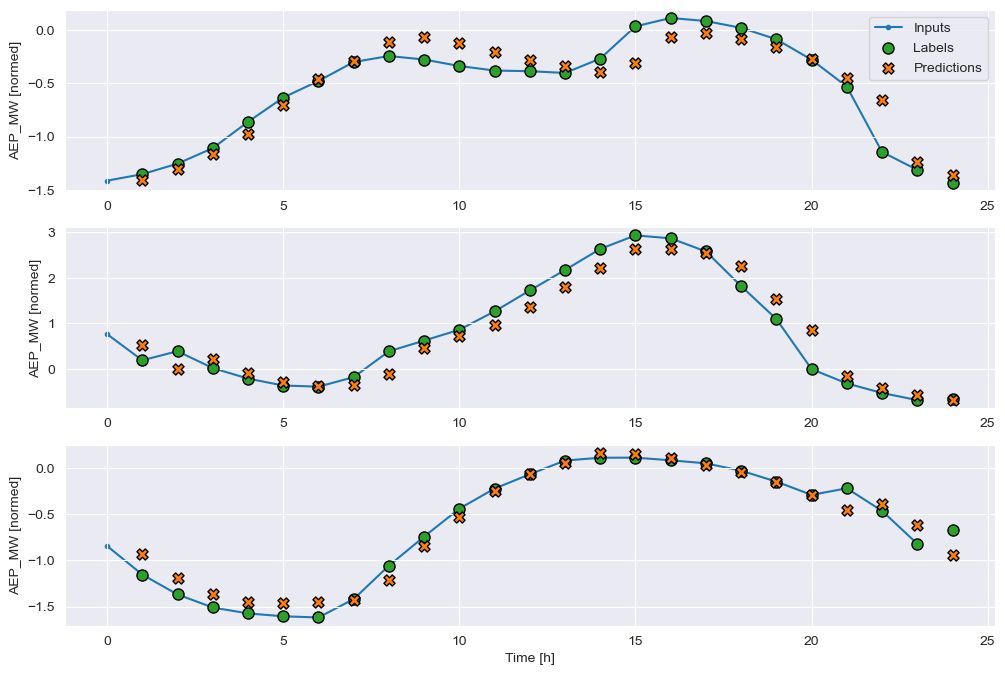

In [71]:
wider_window.plot(plot_col='AEP_MW', model=linear)

The bar plot indicates the contribution of each feature

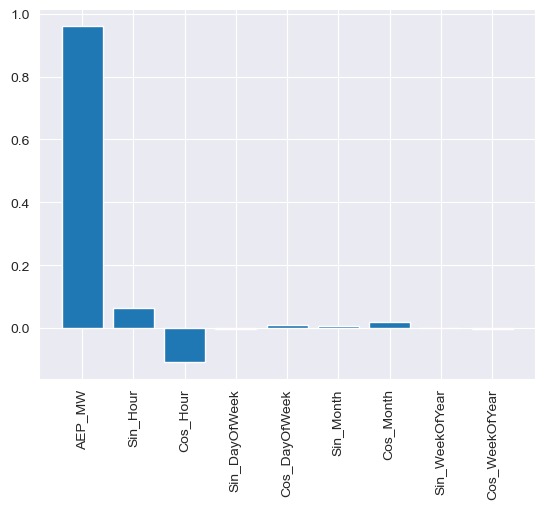

In [72]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

## Applying Deep Dense Model including activation layer and single output
Deep due to the fact of adding multiple hidden layers. Here we apply relu activation function for non-linear computation.

In [73]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

### Train

In [74]:
history = compile_and_fit(dense, single_step_window)

val_perform['Dense'] = dense.evaluate(single_step_window.val)
perform['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


2022-10-05 13:47:13.206503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2648/2648 [==============================] - ETA: 0s - loss: 0.0313 - mean_absolute_error: 0.1120

2022-10-05 13:47:35.197459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2648/2648 [==============================] - 27s 10ms/step - loss: 0.0313 - mean_absolute_error: 0.1120 - val_loss: 0.0219 - val_mean_absolute_error: 0.0920
Epoch 2/20
2648/2648 [==============================] - 25s 10ms/step - loss: 0.0186 - mean_absolute_error: 0.0877 - val_loss: 0.0208 - val_mean_absolute_error: 0.0881
Epoch 3/20
2648/2648 [==============================] - 25s 10ms/step - loss: 0.0166 - mean_absolute_error: 0.0805 - val_loss: 0.0198 - val_mean_absolute_error: 0.0853
Epoch 4/20
2648/2648 [==============================] - 25s 10ms/step - loss: 0.0156 - mean_absolute_error: 0.0768 - val_loss: 0.0201 - val_mean_absolute_error: 0.0906
Epoch 5/20
2648/2648 [==============================] - 25s 10ms/step - loss: 0.0150 - mean_absolute_error: 0.0746 - val_loss: 0.0197 - val_mean_absolute_error: 0.0876
Epoch 6/20
2648/2648 [==============================] - 25s 10ms/step - loss: 0.0144 - mean_absolute_error: 0.0727 - val_loss: 0.0181 - val_mean_absolute_error: 0.0808
Epo

In [75]:
print('Input shape:', wider_window.example[0].shape)
print('Output shape:', baseline(wider_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


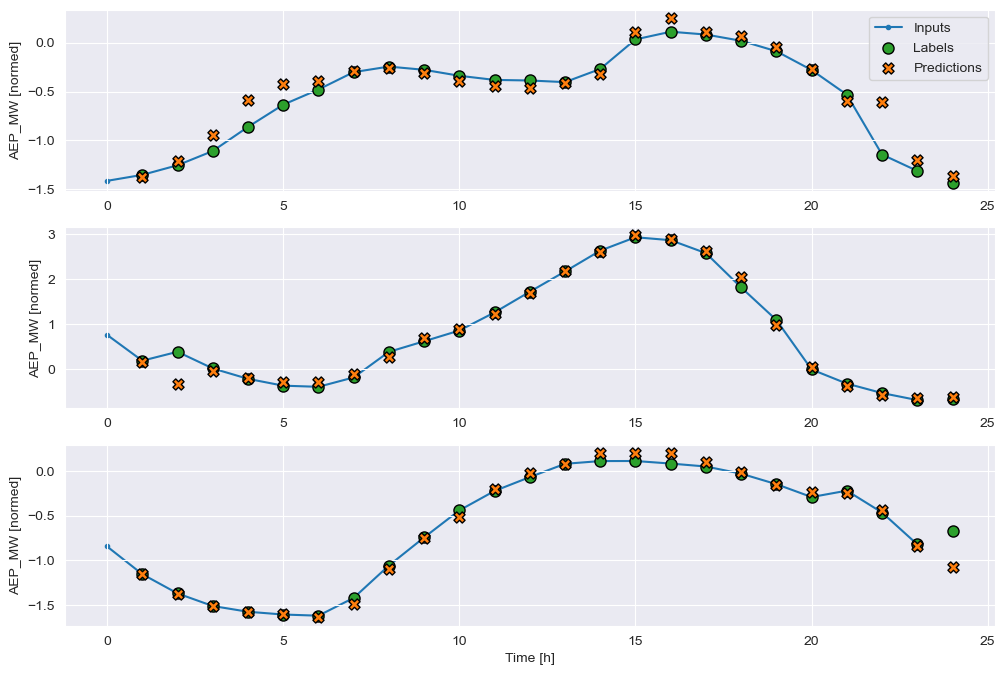

In [76]:
wider_window.plot(plot_col='AEP_MW', model=dense)

## Applying Deep Dense Model with multi-step

The baseline, linear and dense models handled each time step independently. Unfortunately, the models cant see how the input features are changing over time because they are handled each time step independently. A solution is to give the model access to multiple time steps when making predictions. As a result the model will take multiple time steps as input to produce a single output.

Creation of a Window with 3h history, 1h labels and 1h future prediction

In [77]:
CONV_WIDTH = 3
conv_window = WindowGen(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['AEP_MW'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['AEP_MW']

Given 3 hours of inputs, predict 1 hour into the future.


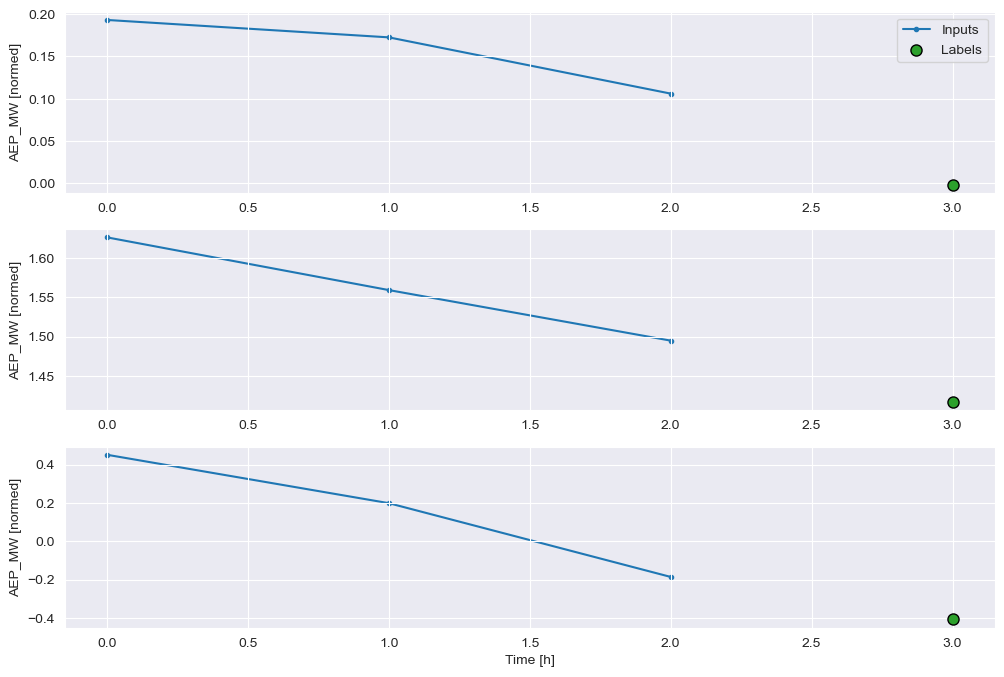

In [78]:
conv_window.plot(plot_col='AEP_MW')
print("Given 3 hours of inputs, predict 1 hour into the future.");

In [79]:
units = 32
activation = 'relu'

model_multi_step_dense = tf.keras.Sequential([
    # Reduce the dims by flattening
    tf.keras.layers.Flatten(),
    # Deeper
    tf.keras.layers.Dense(units=units, activation=activation),
    tf.keras.layers.Dense(units=units, activation=activation),
    # Single output
    tf.keras.layers.Dense(units=1),
    # Reshape to origin dims
    tf.keras.layers.Reshape([1, -1])
])

In [80]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', model_multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 9)
Output shape: (32, 1, 1)


### Train

In [81]:
history = compile_and_fit(model_multi_step_dense, conv_window)

Epoch 1/20


2022-10-05 13:54:33.583486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2648/2648 [==============================] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.1280

2022-10-05 13:54:48.145347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2648/2648 [==============================] - 17s 6ms/step - loss: 0.0373 - mean_absolute_error: 0.1280 - val_loss: 0.0230 - val_mean_absolute_error: 0.0991
Epoch 2/20
2648/2648 [==============================] - 16s 6ms/step - loss: 0.0185 - mean_absolute_error: 0.0902 - val_loss: 0.0200 - val_mean_absolute_error: 0.0876
Epoch 3/20
2648/2648 [==============================] - 15s 6ms/step - loss: 0.0162 - mean_absolute_error: 0.0812 - val_loss: 0.0180 - val_mean_absolute_error: 0.0816
Epoch 4/20
2648/2648 [==============================] - 15s 6ms/step - loss: 0.0151 - mean_absolute_error: 0.0769 - val_loss: 0.0175 - val_mean_absolute_error: 0.0786
Epoch 5/20
2648/2648 [==============================] - 15s 6ms/step - loss: 0.0144 - mean_absolute_error: 0.0740 - val_loss: 0.0184 - val_mean_absolute_error: 0.0849
Epoch 6/20
2648/2648 [==============================] - 15s 6ms/step - loss: 0.0140 - mean_absolute_error: 0.0723 - val_loss: 0.0174 - val_mean_absolute_error: 0.0790
Epoch 7/2

In [82]:
val_perform['multi_step_dense'] = model_multi_step_dense.evaluate(conv_window.val)
perform['multi_step_dense'] = model_multi_step_dense.evaluate(conv_window.test, verbose=0)

757/757 [==============================] - 3s 4ms/step - loss: 0.0164 - mean_absolute_error: 0.0742


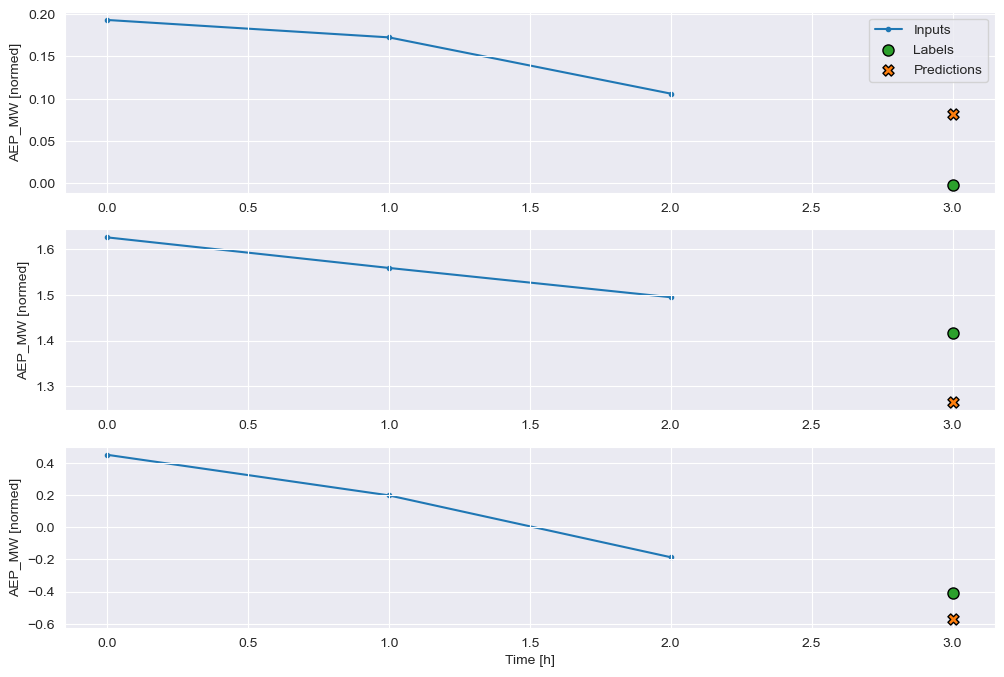

In [83]:
conv_window.plot(plot_col='AEP_MW', model=model_multi_step_dense)

The models' result can only be executed on the shape of input window which is not preferable. This can be solved by applying convolution neural network.

## Applying Convolutional Model with multi-step
Utilizing Convolutional net allows for dynamic window size, in order words we can apply any sized window for prediction.

In [84]:
filters = 32
units = 32
activation = 'relu'

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=filters,
                           kernel_size=(CONV_WIDTH,),
                           activation=activation),
    tf.keras.layers.Dense(units=units, activation=activation),
    tf.keras.layers.Dense(units=1),
])

Running conv model on example dataset to check the expected shape

In [85]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 9)
Output shape: (32, 1, 1)


### Train

In [86]:
history = compile_and_fit(conv_model, conv_window)

Epoch 1/20


2022-10-05 14:56:39.349913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2648/2648 [==============================] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.1260

2022-10-05 14:56:59.392544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2648/2648 [==============================] - 24s 9ms/step - loss: 0.0391 - mean_absolute_error: 0.1260 - val_loss: 0.0211 - val_mean_absolute_error: 0.0918
Epoch 2/20
2648/2648 [==============================] - 23s 9ms/step - loss: 0.0173 - mean_absolute_error: 0.0849 - val_loss: 0.0192 - val_mean_absolute_error: 0.0844
Epoch 3/20
2648/2648 [==============================] - 23s 9ms/step - loss: 0.0154 - mean_absolute_error: 0.0773 - val_loss: 0.0187 - val_mean_absolute_error: 0.0822
Epoch 4/20
2648/2648 [==============================] - 23s 9ms/step - loss: 0.0145 - mean_absolute_error: 0.0737 - val_loss: 0.0177 - val_mean_absolute_error: 0.0785
Epoch 5/20
2648/2648 [==============================] - 23s 9ms/step - loss: 0.0141 - mean_absolute_error: 0.0718 - val_loss: 0.0167 - val_mean_absolute_error: 0.0735
Epoch 6/20
2648/2648 [==============================] - 23s 9ms/step - loss: 0.0138 - mean_absolute_error: 0.0706 - val_loss: 0.0171 - val_mean_absolute_error: 0.0741
Epoch 7/2

In [87]:
val_perform['conv'] = conv_model.evaluate(conv_window.val)
perform['conv'] = conv_model.evaluate(conv_window.test, verbose=0)

757/757 [==============================] - 5s 7ms/step - loss: 0.0176 - mean_absolute_error: 0.0788


Benefit of Convolution opposed to Dense is the acceptance of any input shape

In [88]:
print("Wider window")
print('Input shape:', wider_window.example[0].shape)
print('Labels shape:', wider_window.example[1].shape)
print('Output shape:', conv_model(wider_window.example[0]).shape)

Wider window
Input shape: (32, 24, 9)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Now lets use a wider input -> LABEL_WIDTH + (CONV_WIDTH - 1). Remember, conv width is the kernel size aka filter size.

In [89]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

wide_conv_window = WindowGen(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['AEP_MW'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['AEP_MW']

In [90]:
print("Wider conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wider conv window
Input shape: (32, 26, 9)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


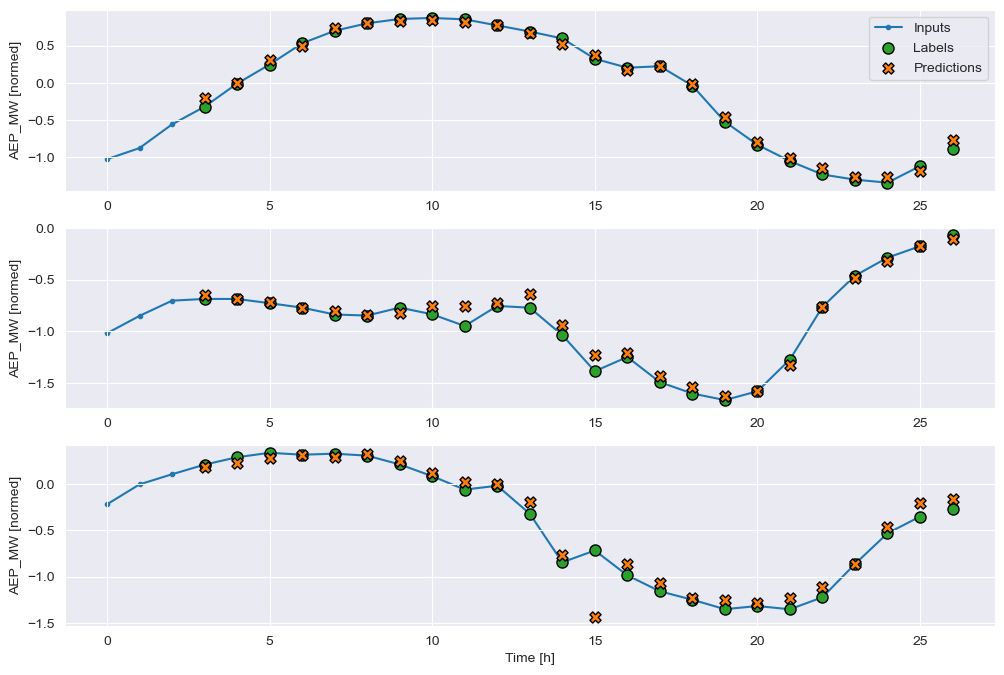

In [91]:
wide_conv_window.plot(plot_col='AEP_MW', model=conv_model)

Every prediction here is based on the 3 preceding time steps!

## Applying Recurrent Neural Network

using 24h history

In [92]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    # We use return_sequences=True in order to train a model on multiple time steps simultaneously
    tf.keras.layers.LSTM(units=32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [93]:
print('Input shape:', wider_window.example[0].shape)
print('Output shape:', lstm_model(wider_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


### Train

In [94]:
history = compile_and_fit(lstm_model, wider_window)

Epoch 1/20


2022-10-05 15:00:17.533571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-05 15:00:17.636933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-05 15:00:17.906979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2647/2647 [==============================] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.1152

2022-10-05 15:00:51.509267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-05 15:00:51.557359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2647/2647 [==============================] - 40s 15ms/step - loss: 0.0386 - mean_absolute_error: 0.1152 - val_loss: 0.0173 - val_mean_absolute_error: 0.0745
Epoch 2/20
2647/2647 [==============================] - 38s 14ms/step - loss: 0.0132 - mean_absolute_error: 0.0668 - val_loss: 0.0151 - val_mean_absolute_error: 0.0660
Epoch 3/20
2647/2647 [==============================] - 38s 14ms/step - loss: 0.0115 - mean_absolute_error: 0.0610 - val_loss: 0.0140 - val_mean_absolute_error: 0.0632
Epoch 4/20
2647/2647 [==============================] - 39s 15ms/step - loss: 0.0106 - mean_absolute_error: 0.0577 - val_loss: 0.0133 - val_mean_absolute_error: 0.0607
Epoch 5/20
2647/2647 [==============================] - 38s 14ms/step - loss: 0.0101 - mean_absolute_error: 0.0557 - val_loss: 0.0136 - val_mean_absolute_error: 0.0602
Epoch 6/20
2647/2647 [==============================] - 36s 13ms/step - loss: 0.0099 - mean_absolute_error: 0.0544 - val_loss: 0.0128 - val_mean_absolute_error: 0.0588
Epo

Saving the trained model

In [95]:
lstm_model.save("../models/model_rnn_lstm-20")

INFO:tensorflow:Assets written to: ../models/model_rnn_lstm-20/assets


INFO:tensorflow:Assets written to: ../models/model_rnn_lstm-20/assets


Loading and casting the pretrained model to BaseModel

In [96]:
import keras

pretrained_model = keras.models.load_model("../models/model_rnn_lstm-20", custom_objects={
    'BaseModel': Baseline
})

In [97]:
val_perform['LSTM'] = lstm_model.evaluate(wider_window.val)
perform['LSTM'] = lstm_model.evaluate(wider_window.test, verbose=0)

756/756 [==============================] - 6s 8ms/step - loss: 0.0125 - mean_absolute_error: 0.0573


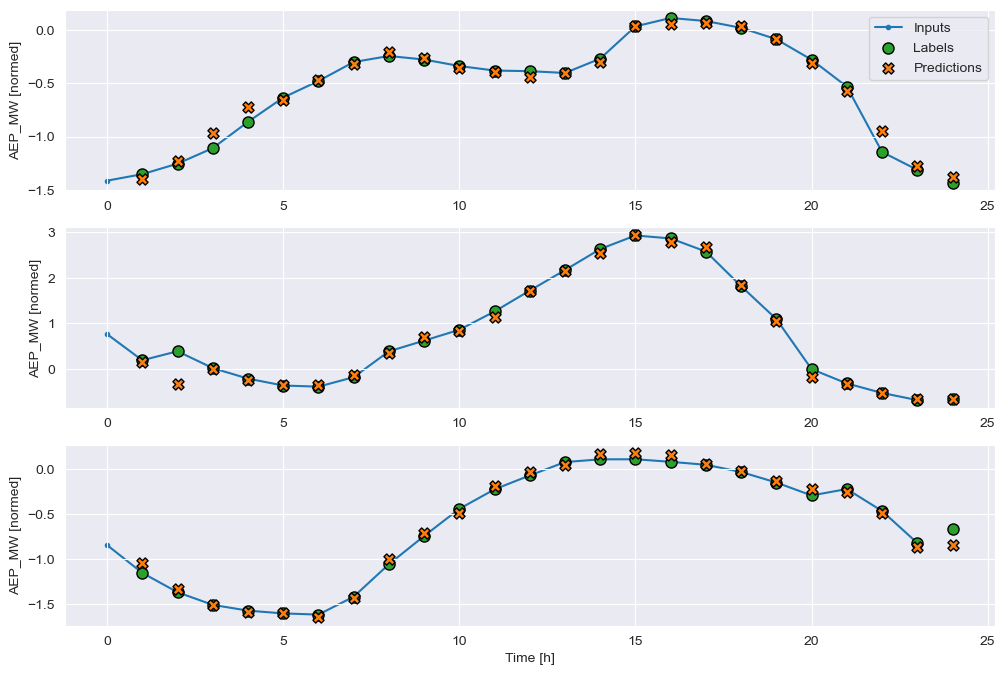

In [98]:
wider_window.plot(plot_col='AEP_MW', model=lstm_model)

## Comparing the models

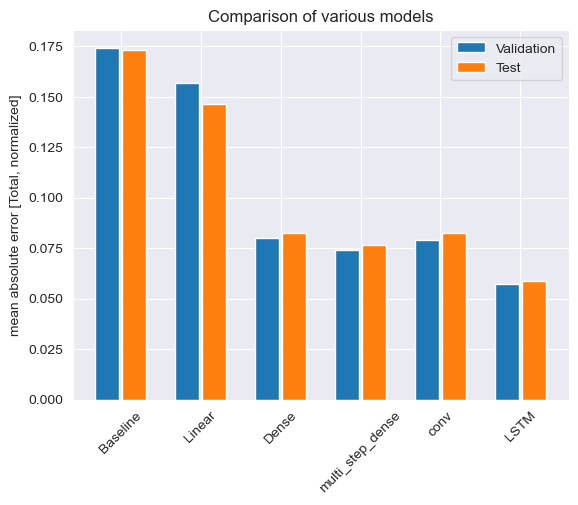

In [99]:
x = np.arange(len(perform))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_perform.values()]
test_mae = [v[metric_index] for v in perform.values()]

plt.ylabel('mean absolute error [Total, normalized]')
plt.title('Comparison of various models')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=perform.keys(),
           rotation=45)

plt.savefig('./comparison.png')
_ = plt.legend()